## 布林带策略逻辑：

1. CCI指标（60分钟趋势过滤）
2. 布林通道（15分钟波动信号）
3. ATR指标（15分钟吊灯Stop止损单）

In [1]:
from __future__ import division

from vnpy.trader.vtObject import VtBarData
from vnpy.trader.vtConstant import EMPTY_STRING
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator, 
                                                     ArrayManager)
import talib as ta

########################################################################
class BollChannelStrategy(CtaTemplate):
    """基于布林通道的交易策略"""
    className = 'BollChannelStrategy'
    author = u'用Python的交易员'

    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典

    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位

    # 策略参数
    bollWindow = 20                      # 布林通道窗口数
    bollDev = 4                         # 布林通道的偏差
    cciWindow = 20                      # CCI窗口数
    atrWindow = 25                      # ATR窗口数
    slMultipler = 3                    # 计算止损距离的乘数
    initDays = 2                        # 初始化数据所用的天数
    fixedSize = 100                       # 每次交易的数量

    # 策略变量
    intraTradeHigh = 0                  # 持仓期内的最高点
    intraTradeLow = 0                   # 持仓期内的最低点
    longStop = 0                        # 多头止损
    shortStop = 0                       # 空头止损
    Trend = 0
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'symbolList',
                 'bollWindow',
                 'bollDev',
                 'cciWindow',
                 'atrWindow',
                 'slMultiplier',
                 'initDays',
                 'fixedSize']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'bollUp',
               'bollDown',
               'cciValue',
               'atrValue',
               'intraTradeHigh',
               'intraTradeLow',
               'longStop',
               'shortStop',
               'Trend']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict',
                'intraTradeHigh',
                'intraTradeLow']    

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(BollChannelStrategy, self).__init__(ctaEngine, setting)
        
        # 生成仓位记录的字典
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"
        
        self.bg15Dict = {
            sym: BarGenerator(self.onBar, 15, self.on15minBar)
            for sym in self.symbolList
        }
        
        self.bg60Dict = {
            sym: BarGenerator(self.onBar, 60, self.on60minBar)
            for sym in self.symbolList
        }
        
        
        self.am15Dict = {
            sym: ArrayManager(size=self.bollWindow*2)
            for sym in self.symbolList
        }
        
        self.am60Dict = {
            sym: ArrayManager(size=self.cciWindow*2)
            for sym in self.symbolList
        }
        
        self.intraTradeHighDict = {}
        self.intraTradeLowDict = {}

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
        self.ctaEngine.initPosition(self)
        # 载入历史数据，并采用回放计算的方式初始化策略数值
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）""" 
        self.bgDict[tick.vtSymbol].updateTick(tick)

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        bg15 = self.bg15Dict[symbol]
        bg15.updateBar(bar)
        
        bg60 = self.bg60Dict[symbol]
        bg60.updateBar(bar)
    
    #----------------------------------------------------------------------
    def on60minBar(self, bar):
        symbol = bar.vtSymbol

        # 保存K线数据
        am60 = self.am60Dict[symbol]
        am60.updateBar(bar)
        
        if not am60.inited:
            return
        
        cciValue = am60.cci(self.cciWindow)
        if cciValue > 0:
            self.Trend = 1
        if cciValue < 0:
            self.Trend = -1
        
    def on15minBar(self, bar):
        symbol = bar.vtSymbol

        # 保存K线数据
        am15 = self.am15Dict[symbol]
        am15.updateBar(bar)
        
        if not am15.inited:
            return
        # 计算指标数值
        bollUp, bollMean ,bollDown = ta.BBANDS(am15.close, self.bollWindow, self.bollDev)
        atrValue = ta.ATR(am15.high, am15.low, am15.close, self.atrWindow)
        
#         判断是否要进行交易
#         当前无仓位，发送开仓委托
        if self.posDict[self.Longpos] == 0 and self.posDict[self.Shortpos] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999
            if self.Trend==1:
                if am15.close[-1]>=bollUp[-1] and am15.close[-2]<=bollUp[-2]:
                    self.buy(symbol, bar.close*1.1 , self.fixedSize)
            elif self.Trend==-1:
                if am15.close[-1]<=bollUp[-1] and am15.close[-2]>=bollUp[-2]:
                    self.short(symbol, bar.close*0.9, self.fixedSize)

        # 持有多头仓位
        elif self.posDict[self.Longpos] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.intraTradeLowDict[symbol] = bar.low
            self.longStop = self.intraTradeHighDict[symbol] - atrValue[-1] * self.slMultipler
            self.cancelAll()
            self.sell(symbol, self.longStop, self.posDict[self.Longpos], True) # 发送Stop单

#         # 持有空头仓位
        elif self.posDict[self.Shortpos] > 0:
            self.intraTradeHighDict[symbol] = bar.high
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.shortStop = self.intraTradeLowDict[symbol] + atrValue[-1] * self.slMultipler
            self.cancelAll()
            self.cover(symbol, self.shortStop, self.posDict[self.Shortpos], True) # 发送Stop单
        
        self.saveSyncData()        
        # 发出状态更新事件
        self.putEvent()        

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
#         print(self.posDict)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [2]:
def runBacktesting(strategyClass, settingDict, 
                   startDate, endDate, slippage, 
                   rate, size, priceTick):
    """运行单标的回测"""
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase(MINUTE_DB_NAME)
    engine.setStartDate(startDate, initDays=1)
    engine.setEndDate(endDate)
    engine.setSlippage(slippage)
    engine.setRate(rate)   
    engine.setSize(size)         
    engine.setPriceTick(priceTick)
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)
    engine.runBacktesting()

    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    df = engine.calculateDailyResult()
    return df

2018-07-14 14:49:04.914186	开始回测
2018-07-14 14:49:04.914186	策略初始化
2018-07-14 14:49:04.914186	载入历史数据。数据范围:[20171231,20180101)
2018-07-14 14:49:05.077021	载入完成，数据量：1414
2018-07-14 14:49:05.087009	策略初始化完成
2018-07-14 14:49:05.087009	策略启动完成
2018-07-14 14:49:05.088007	开始回放回测数据,回测范围:[20180101,20180701)
2018-07-14 14:49:05.088007	载入历史数据。数据范围:[20180101,20180311)
2018-07-14 14:49:13.551367	载入完成，数据量：99357
2018-07-14 14:49:13.552367	当前回放数据:[20180101,20180311)
2018-07-14 14:49:14.915974	载入历史数据。数据范围:[20180311,20180519)
2018-07-14 14:49:23.193523	载入完成，数据量：99073
2018-07-14 14:49:23.229486	当前回放数据:[20180311,20180519)
2018-07-14 14:49:24.465225	载入历史数据。数据范围:[20180519,20180701)
2018-07-14 14:49:29.492093	载入完成，数据量：61359
2018-07-14 14:49:29.533051	当前回放数据:[20180519,20180701)
2018-07-14 14:49:30.350217	数据回放结束ss: 100%    
2018-07-14 14:49:30.351215	计算按日统计结果
2018-07-14 14:49:30.371195	------------------------------
2018-07-14 14:49:30.371195	首个交易日：	2018-01-01
2018-07-14 14:49:30.371195	最后交易日：	2018-06-30
2018-07-14

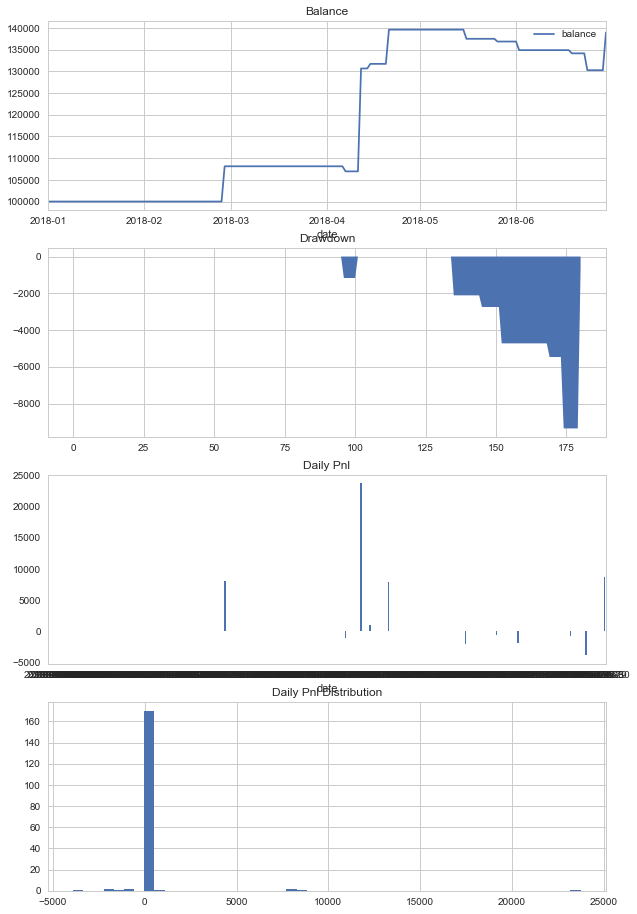

2018-07-14 14:49:32.073457	计算回测结果
2018-07-14 14:49:32.075455	------------------------------
2018-07-14 14:49:32.075455	第一笔交易：	2018-02-27 16:16:00
2018-07-14 14:49:32.075455	最后一笔交易：	2018-06-30 06:46:00
2018-07-14 14:49:32.075455	总交易次数：	11
2018-07-14 14:49:32.075455	总盈亏：	38,982.25
2018-07-14 14:49:32.075455	最大回撤: 	-9,353.66
2018-07-14 14:49:32.075455	平均每笔盈利：	3,543.84
2018-07-14 14:49:32.075455	平均每笔滑点：	40.0
2018-07-14 14:49:32.075455	平均每笔佣金：	1,544.34
2018-07-14 14:49:32.075455	胜率		45.45%
2018-07-14 14:49:32.075455	盈利交易平均值	9,900.84
2018-07-14 14:49:32.075455	亏损交易平均值	-1,753.66
2018-07-14 14:49:32.075455	盈亏比：	5.65


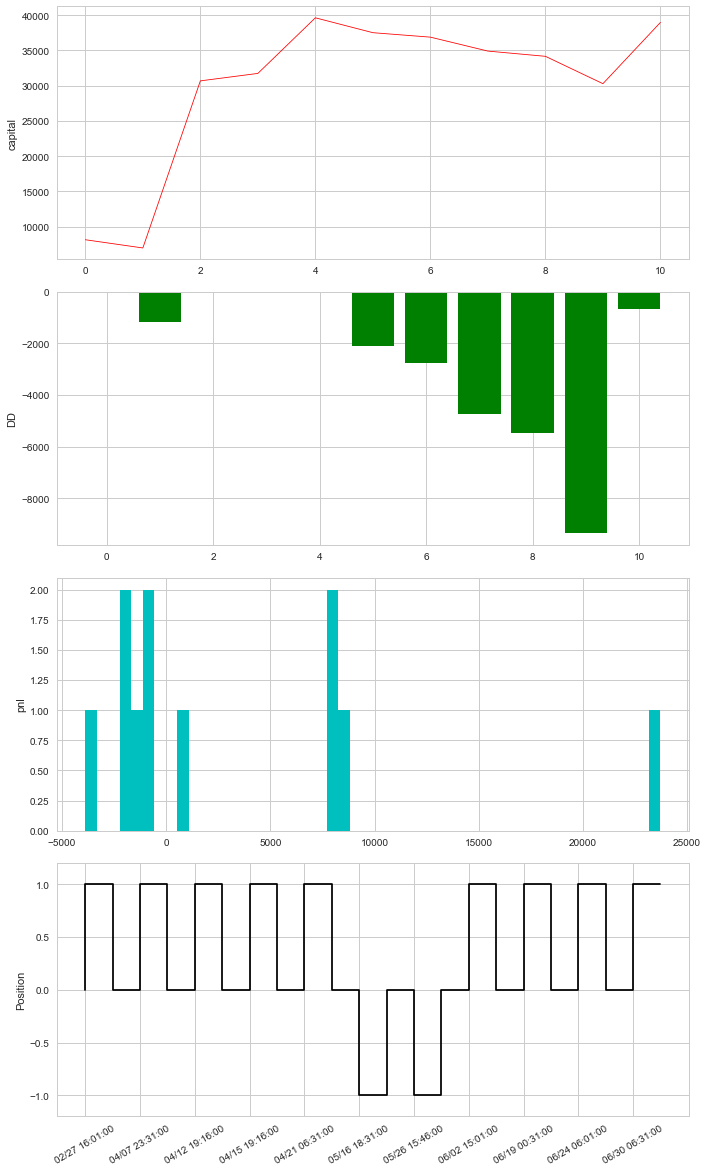

2018-07-14 14:49:32.858655	计算按日统计结果


In [3]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME

    bollDf = runBacktesting(BollChannelStrategy, {'symbolList':['tBTCUSD:bitfinex']} , '20180101', '20180630', 0.2, 1/1000, 1, 0.01)

## ATR_RSI策略逻辑
1. ATR>maAtr: 波动放大
2. RSI>50+rsiEntry, 趋势向上 买入
3. RSI<50-rsiEntry, 趋势向下 卖出

In [4]:
from __future__ import division

from vnpy.trader.vtObject import VtBarData
from vnpy.trader.vtConstant import EMPTY_STRING
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator, 
                                                     ArrayManager)
import talib as ta

########################################################################
class AtrRsiStrategy(CtaTemplate):
    """基于布林通道的交易策略"""
    className = 'AtrRsiStrategy'
    author = u'用Python的交易员'

    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典

    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位

    # 策略参数
    atrLength = 40        # 计算ATR指标的窗口数   
    atrMaLength = 40       # 计算ATR均线的窗口数
    rsiLength = 40        # 计算RSI的窗口数
    rsiEntry = 10         # RSI的开仓信号
    trailingPercent = 0.4  # 百分比移动止损
    initDays = 1           # 初始化数据所用的天数
    fixedSize = 1           # 每次交易的数量
    
    
    # 策略变量
    atrValue = 0                        # 最新的ATR指标数值
    atrMa = 0                           # ATR移动平均的数值
    rsiValue = 0                        # RSI指标的数值
    rsiBuy = 0                          # RSI买开阈值
    rsiSell = 0                         # RSI卖开阈值
    intraTradeHigh = 0                  # 移动止损用的持仓期内最高价
    intraTradeLow = 0                   # 移动止损用的持仓期内最低价
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'symbolList',
                 'atrLength',
                 'atrMaLength',
                 'rsiLength',
                 'rsiEntry',
                 'trailingPercent']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'atrValue',
               'atrMa',
               'rsiValue',
               'rsiBuy',
               'rsiSell']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict',
                'intraTradeHigh',
                'intraTradeLow']    

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(AtrRsiStrategy, self).__init__(ctaEngine, setting)
        
        # 生成仓位记录的字典
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"
        
        self.bg15Dict = {
            sym: BarGenerator(self.onBar, 15, self.on15minBar)
            for sym in self.symbolList
        }
        
        self.am15Dict = {
            sym: ArrayManager(size=self.atrLength*3)
            for sym in self.symbolList
        }
       
        self.intraTradeHighDict = {}
        self.intraTradeLowDict = {}

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
        self.ctaEngine.initPosition(self)
        
        # 初始化RSI入场阈值
        self.rsiBuy = 50 + self.rsiEntry
        self.rsiSell = 50 - self.rsiEntry
        
        # 载入历史数据，并采用回放计算的方式初始化策略数值
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）""" 
        self.bgDict[tick.vtSymbol].updateTick(tick)

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        bg15 = self.bg15Dict[symbol]
        bg15.updateBar(bar)
        
    def on15minBar(self, bar):
        symbol = bar.vtSymbol

        # 建立数组-----------------------------------------------------------------
        am15 = self.am15Dict[symbol]
        am15.updateBar(bar)
        
        if not am15.inited:
            return
        # 计算指标数组-------------------------------------------------------------
        atr = ta.ATR(am15.high, am15.low, am15.close, self.atrLength)
        atrMa = ta.MA(atr, self.atrMaLength)
        rsiValue = ta.RSI(am15.close, self.rsiLength)
        
        # 进出场信号---------------------------------------------------------------
        if self.posDict[self.Longpos] == 0 and self.posDict[self.Shortpos] == 0:
            self.intraTradeHighDict[symbol] = bar.high
            self.intraTradeLowDict[symbol] = bar.low
            if atr[-1] >= atrMa[-1] and atr[-2] <= atrMa[-2]:
                if rsiValue[-1] > self.rsiBuy:
                    self.buy(symbol, bar.close+1, self.fixedSize)
            elif atr[-1] <= atrMa[-1] and atr[-2] >= atrMa[-2]:
                if rsiValue[-1] < self.rsiSell:
                    self.short(symbol, bar.close-1, self.fixedSize)
                    

        # 持有多头仓位
        elif self.posDict[self.Longpos] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.intraTradeLowDict[symbol] = bar.low
            longStop =  self.intraTradeHighDict[symbol] * (1-self.trailingPercent/100)
            self.cancelAll()
            self.sell(symbol, longStop, self.posDict[self.Longpos], True)

#         # 持有空头仓位
        elif self.posDict[self.Shortpos] > 0:
            self.intraTradeHighDict[symbol] = bar.high
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            shortStop = self.intraTradeLowDict[symbol] * (1+self.trailingPercent/100)
            self.cancelAll()
            self.cover(symbol, shortStop, self.posDict[self.Shortpos], True)

        self.saveSyncData()        
        # 发出状态更新事件
        self.putEvent()        

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        print(self.posDict)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

2018-07-14 14:49:33.122386	开始回测
2018-07-14 14:49:33.122386	策略初始化
2018-07-14 14:49:33.122386	载入历史数据。数据范围:[20171231,20180101)
2018-07-14 14:49:33.260244	载入完成，数据量：1414
2018-07-14 14:49:33.277228	策略初始化完成
2018-07-14 14:49:33.278227	策略启动完成
2018-07-14 14:49:33.278227	开始回放回测数据,回测范围:[20180101,20180701)
2018-07-14 14:49:33.279226	载入历史数据。数据范围:[20180101,20180311)
2018-07-14 14:49:41.411924	载入完成，数据量：99357
2018-07-14 14:49:41.411924	当前回放数据:[20180101,20180311)
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0,

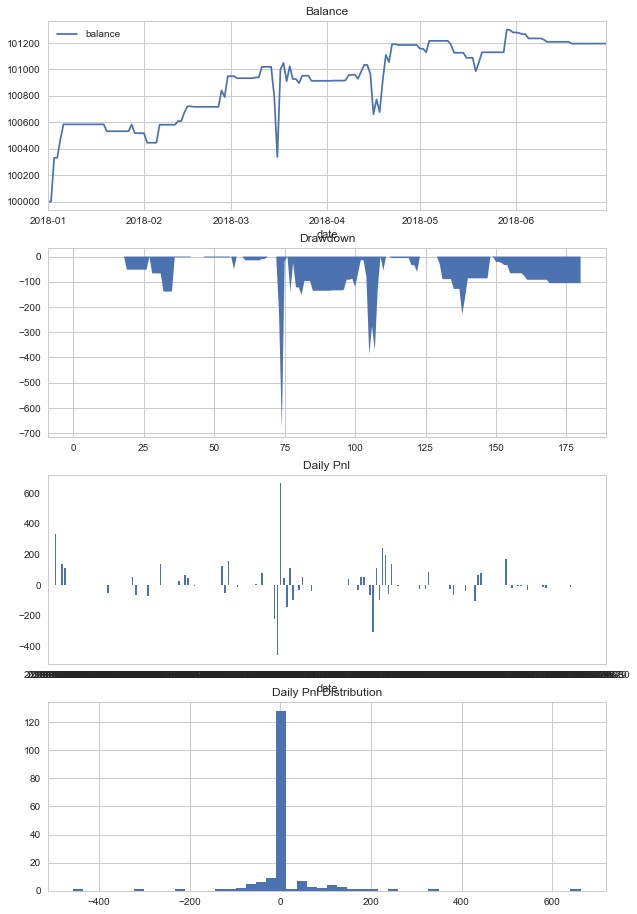

2018-07-14 14:49:59.037929	计算回测结果
2018-07-14 14:49:59.044920	------------------------------
2018-07-14 14:49:59.044920	第一笔交易：	2018-01-03 02:46:00
2018-07-14 14:49:59.044920	最后一笔交易：	2018-06-19 20:07:00
2018-07-14 14:49:59.044920	总交易次数：	79
2018-07-14 14:49:59.044920	总盈亏：	1,194.52
2018-07-14 14:49:59.044920	最大回撤: 	-181.36
2018-07-14 14:49:59.044920	平均每笔盈利：	15.12
2018-07-14 14:49:59.044920	平均每笔滑点：	0.4
2018-07-14 14:49:59.044920	平均每笔佣金：	18.54
2018-07-14 14:49:59.044920	胜率		50.63%
2018-07-14 14:49:59.044920	盈利交易平均值	51.68
2018-07-14 14:49:59.044920	亏损交易平均值	-22.37
2018-07-14 14:49:59.044920	盈亏比：	2.31


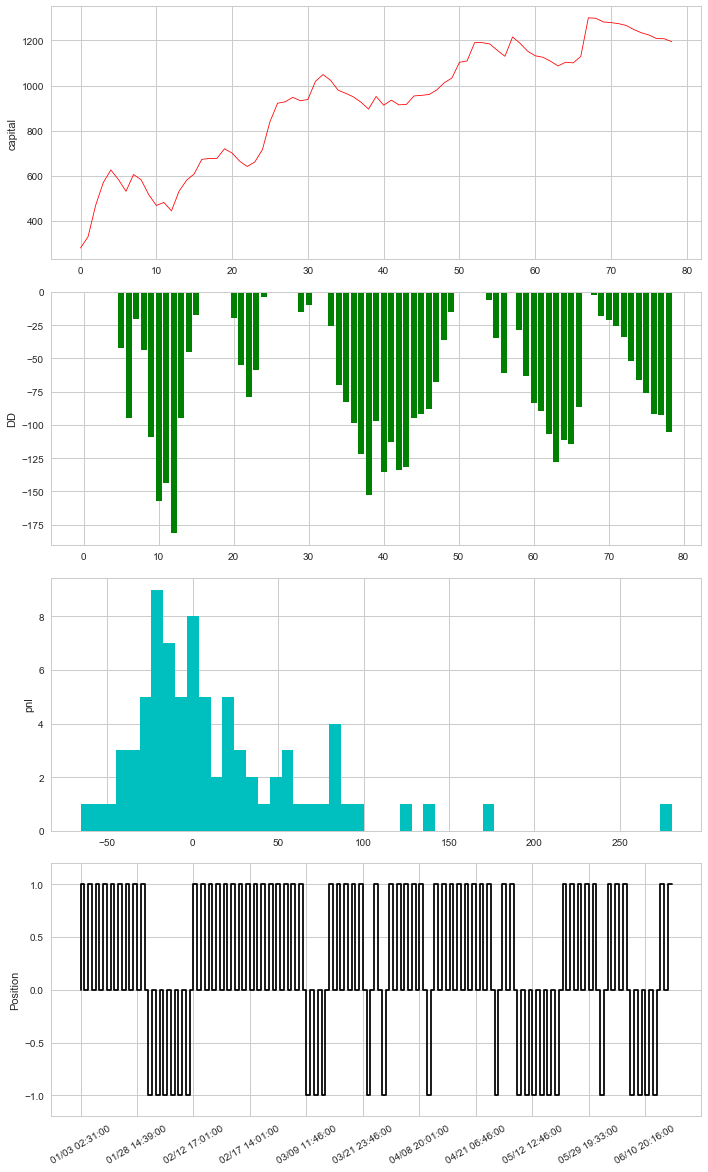

2018-07-14 14:49:59.823124	计算按日统计结果


In [5]:
atrRsiDf = runBacktesting(AtrRsiStrategy, {'symbolList':['tBTCUSD:bitfinex']} , '20180101', '20180630', 0.2, 1/1000, 1, 0.01)

## Strategy_Portfolio

In [6]:
PortfolioDf = atrRsiDf+bollDf

2018-07-14 14:49:59.879068	------------------------------
2018-07-14 14:49:59.879068	首个交易日：	2018-01-01
2018-07-14 14:49:59.879068	最后交易日：	2018-06-30
2018-07-14 14:49:59.879068	总交易日：	181
2018-07-14 14:49:59.879068	盈利交易日	33
2018-07-14 14:49:59.879068	亏损交易日：	32
2018-07-14 14:49:59.879068	起始资金：	1000000
2018-07-14 14:49:59.879068	结束资金：	1,040,176.77
2018-07-14 14:49:59.879068	总收益率：	4.02%
2018-07-14 14:49:59.879068	年化收益：	5.33%
2018-07-14 14:49:59.879068	总盈亏：	40,176.77
2018-07-14 14:49:59.879068	最大回撤: 	-9,374.34
2018-07-14 14:49:59.879068	百分比最大回撤: -0.9%
2018-07-14 14:49:59.879068	总手续费：	18,452.72
2018-07-14 14:49:59.879068	总滑点：	471.6
2018-07-14 14:49:59.879068	总成交金额：	18,452,716.54
2018-07-14 14:49:59.879068	总成交笔数：	180
2018-07-14 14:49:59.879068	日均盈亏：	221.97
2018-07-14 14:49:59.879068	日均手续费：	101.95
2018-07-14 14:49:59.879068	日均滑点：	2.61
2018-07-14 14:49:59.879068	日均成交金额：	101,948.71
2018-07-14 14:49:59.879068	日均成交笔数：	0.99
2018-07-14 14:49:59.879068	日均收益率：	0.02%
2018-07-14 14:49:59.879068	收益标准差：	0.2

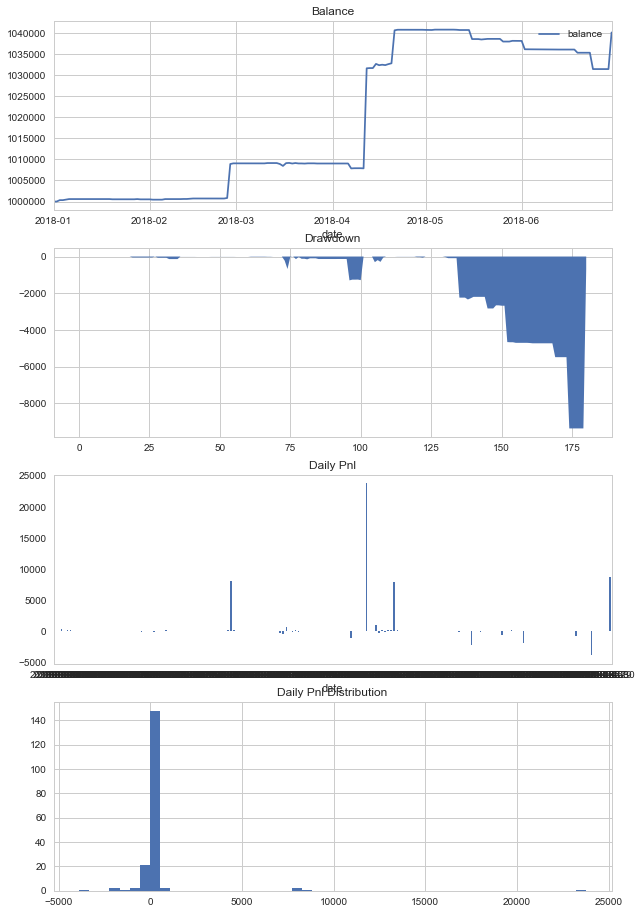

In [7]:
PortfolioDf = PortfolioDf.dropna()

# 创建回测引擎，并设置组合回测初始资金后，显示结果
engine = BacktestingEngine()
engine.setCapital(1000000)
dfp, result = engine.calculateDailyStatistics(PortfolioDf)
engine.showDailyResult(PortfolioDf, result)